# Experiments simulation 7


## Imports

In [1]:
import os, sys, random, pickle
from datetime import datetime
from zoneinfo import ZoneInfo  
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from BigEDA.descriptive import outliers_table
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix
from FastKmedoids.plots import clustering_MDS_plot_multiple_methods
from PyDistances.mixed import FastGGowerDistMatrix
sns.set_style('whitegrid')

current_path = os.getcwd()
src_path = os.path.join(current_path, '..', '..', 'src')
config_path = os.path.join(current_path, '..', '..', 'config')
sys.path.append(src_path)
sys.path.append(config_path)

from simulations_utils import get_simulation_8

from experiments_utils import (make_experiment_1, 
                               make_experiment_3, 
                               make_experiment_4,
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names, 
                               split_list_in_chunks)

from config_experiment_1_simulation_8 import get_config as get_config_exp_1_sim_8
from config_experiment_3_simulation_8 import get_config as get_config_exp_3_sim_8
from config_experiment_4_simulation_8 import get_config as get_config_exp_4_sim_8


## Data Simulation

In [2]:
X, y, outliers_idx = get_simulation_8(random_state=123, return_outlier_idx=True)

In [3]:
# polars conversion for data exploration
X_pl = pl.from_pandas(X)

## Data Exploration

In [4]:
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8
0,1.638784,-2.139096,-2.877908,2.850896,1,0,3,0
1,0.308971,-5.512627,-1.130451,0.079392,0,1,3,3
2,-22.167826,-16.779497,-6.693506,0.907840,1,0,3,3
3,4.737270,-2.875537,-4.152888,1.200392,1,0,3,3
4,3.061934,-3.639231,-2.762178,1.639456,1,0,3,0


In [5]:
X.shape

(300000, 8)

In [6]:
# Proportion of individuals per cluster/group
unique_values, counts = np.unique(y, return_counts=True)
prop_clusters = counts/len(y)
prop_clusters = {k: v for k, v in zip(unique_values, prop_clusters)}
print(f'prop_clusters: {prop_clusters}')

prop_clusters: {0: 0.2, 1: 0.3, 2: 0.5}


In [7]:
# Outliers information
outliers_table(X_pl, auto=False, col_names=['X1', 'X2', 'X3', 'X4'], h=1.5)

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""X1""",-18.898502,12.940488,14482,285518,0.048273,0.951727
"""X2""",-14.405355,4.517195,15066,284934,0.05022,0.94978
"""X3""",-11.955449,8.384316,829,299171,0.002763,0.997237
"""X4""",-6.732431,10.657387,1171,298829,0.003903,0.996097


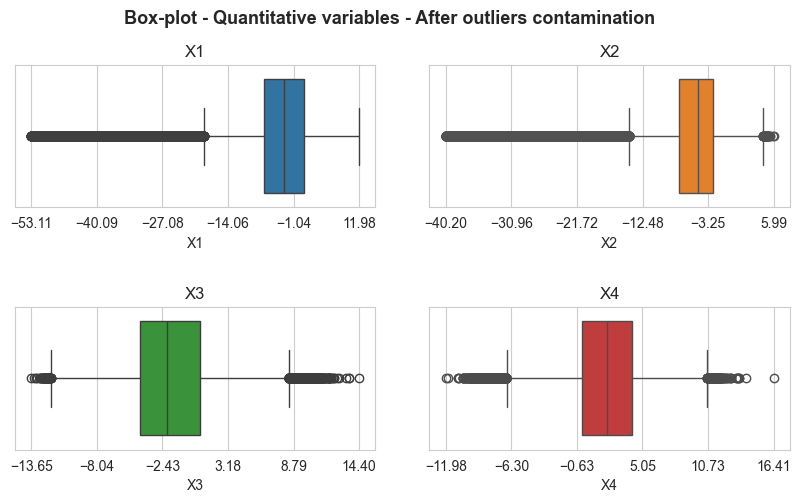

In [8]:
# Boxplot after outliers contamination
boxplot_matrix(X_pl, 
               n_cols=2, 
               title='Box-plot - Quantitative variables - After outliers contamination', 
               figsize=(10,5), 
               quant_col_names=['X1', 'X2', 'X3', 'X4'], 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)

In [9]:
# Boxplot before outliers contamination
'''
boxplot_matrix(X_not_outliers, 
               n_cols=2, 
               title='Box-plot - Quantitative variables - Before outliers contamination', 
               figsize=(10,5), 
               quant_col_names=['X1', 'X2', 'X3', 'X4'], 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)
'''

"\nboxplot_matrix(X_not_outliers, \n               n_cols=2, \n               title='Box-plot - Quantitative variables - Before outliers contamination', \n               figsize=(10,5), \n               quant_col_names=['X1', 'X2', 'X3', 'X4'], \n               n_xticks=6, \n               title_fontsize=13, \n               save=False, \n               file_name='', \n               x_rotation=0, \n               title_height=0.99,\n               style='whitegrid', \n               hspace=0.7, \n               wspace=0.15, \n               title_weight='bold',\n               subtitles_fontsize=12, \n               xlabel_size=10)\n"

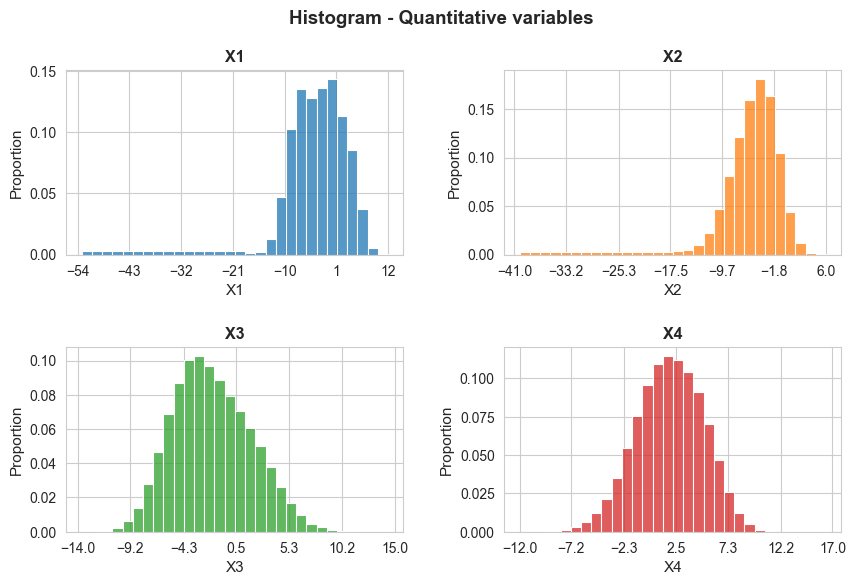

In [10]:
# Histogram
histogram_matrix(df=X_pl, bins=30, n_cols=2, title='Histogram - Quantitative variables', 
                 figsize=(10,6), quant_col_names=['X1', 'X2', 'X3', 'X4'], 
                 n_xticks=7, title_fontsize=13.5, 
                 subtitles_fontsize=11.5, save=False, file_name='', x_rotation=0, title_height=0.98,
                 style='whitegrid', hspace=0.5, wspace=0.3, n_round_xticks=1)

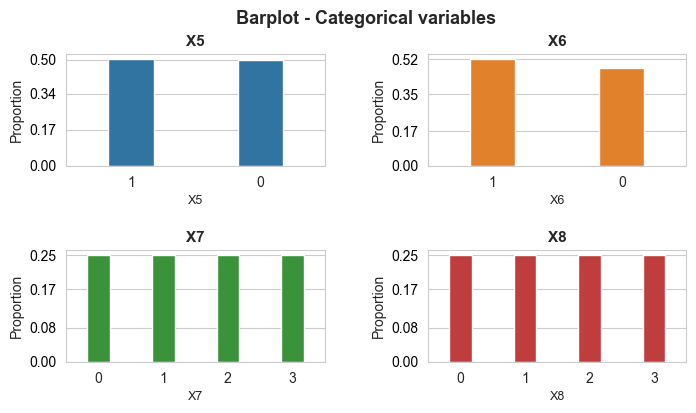

In [11]:
# Barplot
barplot_matrix(df=X_pl, n_cols=2, title='Barplot - Categorical variables', 
                 figsize=(8,4), cat_col_names=['X5', 'X6', 'X7', 'X8'], 
                 title_fontsize=13, subtitles_fontsize=11, 
                 save=False, file_name='', x_rotation=0, title_height=0.99,
                 style='whitegrid', hspace=0.75, wspace=0.4, title_weight='bold', bar_width=0.35,
                 ylabel_size=10, xlabel_size=9, xticks_size=10)

In [12]:
# Correlation Matrix
X[['X1', 'X2', 'X3', 'X4']].corr()

,X1,X2,X3,X4
X1,1.000000,0.822834,-0.309031,0.104995
X2,0.822834,1.000000,-0.157128,0.159449
X3,-0.309031,-0.157128,1.000000,-0.180008
X4,0.104995,0.159449,-0.180008,1.000000


In [13]:
# Correlation Analysis
corr_matrix = X[['X1', 'X2', 'X3', 'X4']].corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))

Proportion of pair-wise correlation > 0.60 (in abs. value):  0.17
Proportion of pair-wise correlations in [0.30, 0.60]:  0.17
Proportion of pair-wise correlation < 0.30 (in abs. value):  0.67


## Experiment 1: Accuracy and computation time for Fast k-medoids (section 3.2)

In [14]:
run_experiment_1 = True

In [15]:
if run_experiment_1: 
        
    n_realizations = 1
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'simulation_7')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    
    experiment_1_config = get_config_exp_1_sim_8()

    X, y = get_simulation_8(random_state=experiment_random_state, return_outlier_idx=False)


In [42]:
if run_experiment_1: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print("chunk_id:", chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)
                
            results[random_state] = make_experiment_1(**experiment_1_config,
                                                      X=X, 
                                                      y=y,
                                                      random_state=random_state)
            
        # Save results
        results_filename = f'results_exp_1_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 70 realization 
## IBiDat Server: 80*22 mins = 1760 mins

chunks:   0%|          | 0/1 [00:00<?, ?chunks/s]

chunk_id: 0
random_state_chunk: [53]
random_state: 53
frac_sample_size: 0.0005
len y_pred: 3
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1


chunks:   0%|          | 0/1 [08:00<?, ?chunks/s]


MemoryError: Unable to allocate 6.71 GiB for an array with shape (30000, 30000) and data type float64

In [ ]:
if run_experiment_1: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_chunk = {}
    file_id = '20251009_164200'
    results_folder_path = os.path.join(current_path, '..', '..',  'results', 'results_experiment_1', 'simulation_7')
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_1_simu_7_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_1_simu_7_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [ ]:
# Open merged/joined results 
file_id = '20251009_164200'
results_filename = f'results_exp_1_simu_7_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'simulation_7')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [21]:
results

{6863: {'time': {0.0005: 92.86066579818726,
   0.005: 92.57912921905518,
   0.01: 92.89056491851807,
   0.05: 133.1420772075653,
   0.1: 301.58556151390076,
   0.2: 1013.9202024936676},
  'adj_accuracy': {0.0005: 0.8773166666666666,
   0.005: 0.8285366666666667,
   0.01: 0.8320166666666666,
   0.05: 0.7700166666666667,
   0.1: 0.7700133333333333,
   0.2: 0.7667633333333334},
  'ARI': {0.0005: 0.6809218102531636,
   0.005: 0.5913681427122639,
   0.01: 0.5977300756706608,
   0.05: 0.5094552559626202,
   0.1: 0.5094626374965406,
   0.2: 0.5068990784274174}},
 35084: {'time': {0.0005: 92.22998762130737,
   0.005: 91.6388111114502,
   0.01: 92.6452476978302,
   0.05: 132.92018151283264,
   0.1: 236.4708652496338,
   0.2: 714.2626647949219},
  'adj_accuracy': {0.0005: 0.8312933333333333,
   0.005: 0.8403366666666666,
   0.01: 0.8388733333333334,
   0.05: 0.8333,
   0.1: 0.75499,
   0.2: 0.76151},
  'ARI': {0.0005: 0.5984359959226845,
   0.005: 0.6142970408827634,
   0.01: 0.611194935636982,


In [3]:
experiment_1_config = get_config_exp_1_sim_4()

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

In [4]:
frac_sample_sizes_list = np.array(list(avg_results['adj_accuracy'].keys()))
adj_accuracy_list = list(avg_results['adj_accuracy'].values())
ari_list = list(avg_results['ARI'].values())
time_list = list(avg_results['time'].values())
best_frac_sample_size = frac_sample_sizes_list[np.argmax(adj_accuracy_list)]

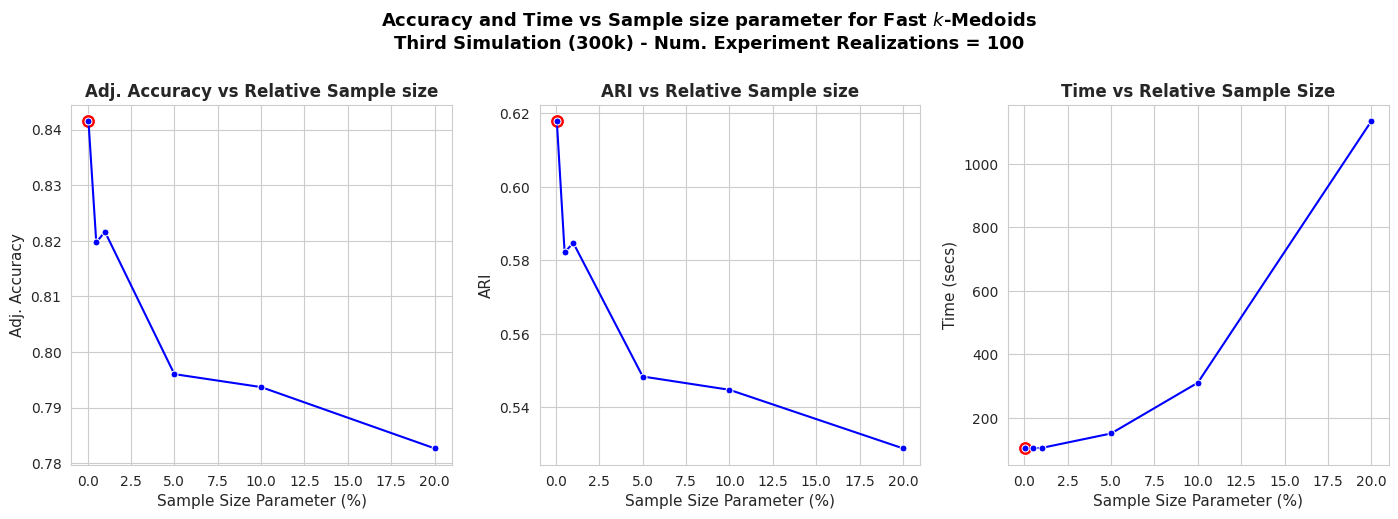

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes = axes.flatten()  

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['adj_accuracy'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[0])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=adj_accuracy_list, 
    color='blue', marker='o',  markersize=5, ax=axes[0]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['ARI'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[1])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=ari_list, 
    color='blue', marker='o',  markersize=5, ax=axes[1]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['time'][best_frac_sample_size]], color='red', marker='o', markersize=10, ax=axes[2])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=time_list, 
    color='blue', marker='o', markersize=5, ax=axes[2]
)

axes[0].set_title('Adj. Accuracy vs Relative Sample size', size=12, weight='bold')
axes[0].set_ylabel('Adj. Accuracy', size=11)
#axes[0].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[1].set_title('ARI vs Relative Sample size', size=12, weight='bold')
axes[1].set_ylabel('ARI', size=11)
#axes[1].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[2].set_title('Time vs Relative Sample Size', size=12, weight='bold')
axes[2].set_ylabel('Time (secs)', size=11)
#axes[2].set_yticks(np.round(np.linspace(np.min(times_values), np.max(times_values), 7),1))

for i in range(len(axes)):
    #axes[i].set_xticks(np.round(np.linspace(np.min(data_perc_sizes), np.max(data_perc_sizes), 7),1))
    axes[i].set_xlabel('Sample Size Parameter (%)', size=11)

#plt.tight_layout()
plt.subplots_adjust(top=0.83)
plt.suptitle('Accuracy and Time vs Sample size parameter for Fast $k$-Medoids\nThird Simulation (300k) - Num. Experiment Realizations = 100', fontsize=13, y=1.02, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

plot_filename = f'plot_results_exp_1_simu_4_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

**Nota:** si queremos que los datos de tiempo sean coherentes con mi pc personal (realista con un PC de  usuario normal) hay que multiplicarlos por 2, ya que el experimento ha sido corrido con el server, y en base a mis pruebas piloto, el serber acorta los tiempos a la mitad, aprox.


In [27]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'frac_sample_size'
avg_results_df

,time,adj_accuracy,ARI
frac_sample_size,,,
0.0005,104.253231,0.841550,0.617907
0.0050,104.551859,0.819730,0.582234
0.0100,105.651368,0.821644,0.584760
0.0500,151.108308,0.796034,0.548425
0.1000,311.055373,0.793704,0.544806
0.2000,1134.878031,0.782681,0.528878


In [28]:
print(best_frac_sample_size)

0.0005



## Experiment 3: Accuracy, computation time and number of folds for q-Fold Fast k-medoids (section 3.4)

In [2]:
run_experiment_3 = True

In [ ]:
if run_experiment_3: 

    n_realizations = 70
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', '..',  'results', 'results_experiment_3', 'simulation_3')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')

    experiment_3_config = get_config_exp_3_sim_4()

    X, y = get_simulation_4(random_state=experiment_random_state, return_outlier_idx=False)

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks[5:]), start=5):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)    

            results[random_state] = make_experiment_3(**experiment_3_config,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state)

        # Save results
        results_filename = f'results_exp_3_simu_4_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 70 realization
## Personal computer: 3000 mins =  hours

  0%|          | 0/19 [00:00<?, ?it/s]

random_state_chunk: [32134, 21466, 218]
random_state: 32134
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:32<00:00, 30.42s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:20<00:00, 28.04s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:27<00:00, 29.45s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:37<00:00, 43.40s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:10<00:00, 13.00s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:25<00:00, 14.50s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:16<00:00, 13.62s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:49<00:00, 16.97s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:15<00:00,  6.77s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:14<00:00,  6.73s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:18<00:00,  6.94s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:24<00:00,  7.21s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:29<00:00,  3.73s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:21<00:00,  3.55s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:18<00:00,  3.47s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:22<00:00,  3.57s/it]


random_state: 21466
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:30<00:00, 30.07s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:12<00:00, 26.50s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:23<00:00, 28.60s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:35<00:00, 43.03s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:28<00:00, 14.85s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:21<00:00, 14.16s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:25<00:00, 14.50s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:56<00:00, 17.68s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:24<00:00,  7.21s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:18<00:00,  6.91s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:24<00:00,  7.22s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:30<00:00,  7.53s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:36<00:00,  3.90s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:46<00:00,  4.17s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:35<00:00,  3.89s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:30<00:00,  3.77s/it]


random_state: 218
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:56<00:00, 23.33s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:09<00:00, 25.91s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:46<00:00, 33.20s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:26<00:00, 41.32s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:49<00:00, 10.93s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:50<00:00, 11.06s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:13<00:00, 13.33s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:37<00:00, 15.71s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:11<00:00,  6.56s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:11<00:00,  6.59s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:12<00:00,  6.61s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:19<00:00,  6.96s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:25<00:00,  3.64s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:28<00:00,  3.72s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:31<00:00,  3.79s/it]


frac_sample_size: 0.15


  5%|▌         | 1/19 [1:58:08<35:26:28, 7088.28s/it]

random_state_chunk: [57183, 11483, 49492]
random_state: 57183
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:02<00:00, 24.48s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:04<00:00, 24.89s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:44<00:00, 32.96s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:36<00:00, 43.34s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:02<00:00, 12.21s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:05<00:00, 12.57s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:21<00:00, 14.11s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:57<00:00, 17.74s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:25<00:00,  7.30s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:21<00:00,  7.10s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:23<00:00,  7.15s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:30<00:00,  7.54s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:34<00:00,  3.86s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:32<00:00,  3.80s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:27<00:00,  3.68s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:30<00:00,  3.77s/it]


random_state: 11483
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:12<00:00, 26.55s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:24<00:00, 28.85s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:37<00:00, 31.55s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:40<00:00, 44.11s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:29<00:00, 14.99s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.71s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:06<00:00, 12.61s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:41<00:00, 16.18s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.93s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:10<00:00,  6.54s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:12<00:00,  6.63s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:22<00:00,  7.15s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:25<00:00,  3.63s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:19<00:00,  3.50s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:19<00:00,  3.48s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:29<00:00,  3.73s/it]


random_state: 49492
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:51<00:00, 22.33s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:06<00:00, 25.30s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:18<00:00, 27.78s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:44<00:00, 44.84s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:51<00:00, 11.19s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:04<00:00, 12.43s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:03<00:00, 12.32s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:41<00:00, 16.16s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:18<00:00,  6.93s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:13<00:00,  6.68s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:11<00:00,  6.56s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:27<00:00,  7.37s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:37<00:00,  3.94s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:30<00:00,  3.77s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:26<00:00,  3.66s/it]


frac_sample_size: 0.15


 11%|█         | 2/19 [3:54:46<33:13:16, 7035.12s/it]

random_state_chunk: [9158, 864, 41347]
random_state: 9158
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:12<00:00, 26.60s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:22<00:00, 28.43s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:56<00:00, 35.21s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:55<00:00, 47.10s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:49<00:00, 10.95s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:52<00:00, 11.23s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:13<00:00, 13.35s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:30<00:00, 15.04s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:57<00:00,  5.87s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:57<00:00,  5.89s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:00<00:00,  6.04s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:18<00:00,  6.95s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:19<00:00,  3.48s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:20<00:00,  3.51s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:28<00:00,  3.71s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:29<00:00,  3.74s/it]


random_state: 864
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:14<00:00, 26.90s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:27<00:00, 29.50s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:55<00:00, 35.09s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:20<00:00, 40.10s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:55<00:00, 11.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:01<00:00, 12.19s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:03<00:00, 12.31s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:44<00:00, 16.47s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.92s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:59<00:00,  5.99s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:12<00:00,  6.63s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:22<00:00,  7.12s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:28<00:00,  3.72s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:18<00:00,  3.46s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:17<00:00,  3.45s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:21<00:00,  3.53s/it]


random_state: 41347
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:12<00:00, 26.50s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:28<00:00, 29.66s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:52<00:00, 34.49s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [04:14<00:00, 50.94s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:13<00:00, 13.35s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:19<00:00, 13.95s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:22<00:00, 14.22s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:28<00:00, 14.82s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:55<00:00,  5.79s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:54<00:00,  5.74s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.95s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:08<00:00,  6.42s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:18<00:00,  3.46s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:20<00:00,  3.52s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:17<00:00,  3.43s/it]


frac_sample_size: 0.15


 16%|█▌        | 3/19 [5:49:06<30:54:42, 6955.15s/it]

random_state_chunk: [58762, 13374, 5752]
random_state: 58762
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:12<00:00, 26.43s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:13<00:00, 26.64s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [03:05<00:00, 37.04s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:51<00:00, 46.24s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:03<00:00, 12.38s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:54<00:00, 11.40s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:09<00:00, 12.96s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:28<00:00, 14.87s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:08<00:00,  6.40s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:53<00:00,  5.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:00<00:00,  6.03s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:08<00:00,  6.42s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:18<00:00,  3.46s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:15<00:00,  3.39s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:15<00:00,  3.39s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:27<00:00,  3.70s/it]


random_state: 13374
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:16<00:00, 27.35s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:23<00:00, 28.78s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [03:02<00:00, 36.48s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [04:25<00:00, 53.14s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:19<00:00, 13.91s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:17<00:00, 13.77s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:34<00:00, 15.41s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [03:00<00:00, 18.01s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:27<00:00,  7.39s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:00<00:00,  6.01s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:10<00:00,  6.51s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:18<00:00,  6.92s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:08<00:00,  3.22s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:04<00:00,  3.11s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:04<00:00,  3.12s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:17<00:00,  3.43s/it]


random_state: 5752
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:02<00:00, 24.50s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:58<00:00, 23.66s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:40<00:00, 32.15s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:48<00:00, 45.73s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:18<00:00, 13.83s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:18<00:00, 13.82s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:26<00:00, 14.64s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:59<00:00, 17.99s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:15<00:00,  6.79s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.92s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:09<00:00,  6.50s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:06<00:00,  6.35s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:39<00:00,  3.99s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:43<00:00,  4.09s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:06<00:00,  3.15s/it]


frac_sample_size: 0.15


 21%|██        | 4/19 [7:45:49<29:03:29, 6974.00s/it]

random_state_chunk: [12158, 18635, 16547]
random_state: 12158
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:07<00:00, 25.53s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:10<00:00, 26.13s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:43<00:00, 32.71s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:46<00:00, 45.40s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:07<00:00, 12.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:09<00:00, 12.95s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:23<00:00, 14.34s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:47<00:00, 16.72s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:13<00:00,  6.68s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:12<00:00,  6.61s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:16<00:00,  6.84s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:24<00:00,  7.24s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:18<00:00,  3.46s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:05<00:00,  3.14s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:01<00:00,  3.04s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:03<00:00,  3.09s/it]


random_state: 18635
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:04<00:00, 24.84s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:55<00:00, 23.08s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:26<00:00, 29.35s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:32<00:00, 42.53s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:11<00:00, 13.15s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:05<00:00, 12.52s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:18<00:00, 13.83s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:47<00:00, 16.74s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:17<00:00,  6.89s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:12<00:00,  6.61s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:05<00:00,  6.26s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:07<00:00,  6.36s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:17<00:00,  3.44s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:03<00:00,  3.10s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:03<00:00,  3.10s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:05<00:00,  3.13s/it]


random_state: 16547
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:48<00:00, 21.62s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:56<00:00, 23.24s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:35<00:00, 31.12s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:52<00:00, 46.45s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:08<00:00, 12.81s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:04<00:00, 12.45s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:20<00:00, 14.09s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:46<00:00, 16.61s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:28<00:00,  7.43s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:20<00:00,  7.01s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:25<00:00,  7.26s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:31<00:00,  7.55s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:34<00:00,  3.87s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:33<00:00,  3.83s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:27<00:00,  3.69s/it]


frac_sample_size: 0.15


 26%|██▋       | 5/19 [9:39:44<26:55:37, 6924.07s/it]

random_state_chunk: [2783, 38247, 56444]
random_state: 2783
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:50<00:00, 22.08s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:53<00:00, 22.70s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:25<00:00, 29.04s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:30<00:00, 42.12s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.84s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:50<00:00, 11.08s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:01<00:00, 12.13s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:44<00:00, 16.50s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:12<00:00,  6.65s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:21<00:00,  7.10s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:26<00:00,  7.32s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:33<00:00,  7.66s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:35<00:00,  3.90s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:19<00:00,  3.49s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:01<00:00,  3.04s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:03<00:00,  3.09s/it]


random_state: 38247
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:48<00:00, 21.67s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:54<00:00, 22.89s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:23<00:00, 28.78s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:27<00:00, 41.55s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:51<00:00, 11.20s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.87s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:24<00:00, 14.41s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:48<00:00, 16.89s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:18<00:00,  6.93s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:21<00:00,  7.09s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:24<00:00,  7.23s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:31<00:00,  7.56s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:38<00:00,  3.95s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:34<00:00,  3.85s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:32<00:00,  3.81s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:40<00:00,  4.00s/it]


random_state: 56444
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:14<00:00, 26.82s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:24<00:00, 28.88s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:36<00:00, 31.39s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:32<00:00, 42.41s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:48<00:00, 10.89s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:53<00:00, 11.37s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:00<00:00, 12.09s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:24<00:00, 14.43s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:00<00:00,  6.00s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:59<00:00,  5.97s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:10<00:00,  6.54s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:27<00:00,  7.37s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:37<00:00,  3.93s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:31<00:00,  3.78s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:25<00:00,  3.63s/it]


frac_sample_size: 0.15


 32%|███▏      | 6/19 [11:33:19<24:52:11, 6887.04s/it]

random_state_chunk: [62511, 34776, 61511]
random_state: 62511
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:03<00:00, 24.73s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:52<00:00, 22.58s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:26<00:00, 29.25s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:37<00:00, 43.54s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:49<00:00, 10.93s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:51<00:00, 11.20s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:03<00:00, 12.32s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:33<00:00, 15.39s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:12<00:00,  6.63s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:19<00:00,  6.98s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:14<00:00,  6.71s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:17<00:00,  6.87s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:38<00:00,  3.97s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:30<00:00,  3.77s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:28<00:00,  3.70s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:32<00:00,  3.81s/it]


random_state: 34776
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:17<00:00, 27.45s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:20<00:00, 28.05s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [03:02<00:00, 36.60s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [04:06<00:00, 49.31s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:07<00:00, 12.72s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:54<00:00, 11.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:00<00:00, 12.02s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:31<00:00, 15.20s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:01<00:00,  6.09s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:56<00:00,  5.80s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:00<00:00,  6.02s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:06<00:00,  6.30s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:11<00:00,  3.28s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:18<00:00,  3.47s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:17<00:00,  3.45s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:35<00:00,  3.89s/it]


random_state: 61511
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:36<00:00, 31.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:19<00:00, 27.93s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [03:02<00:00, 36.47s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:48<00:00, 45.62s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:50<00:00, 11.09s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:52<00:00, 11.24s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:02<00:00, 12.23s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:26<00:00, 14.60s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:02<00:00,  6.13s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:57<00:00,  5.88s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:06<00:00,  6.33s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:24<00:00,  7.20s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:22<00:00,  3.57s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:19<00:00,  3.49s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:31<00:00,  3.80s/it]


frac_sample_size: 0.15


 37%|███▋      | 7/19 [13:27:23<22:54:33, 6872.76s/it]

random_state_chunk: [4816, 39989, 45018]
random_state: 4816
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:12<00:00, 26.53s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:24<00:00, 28.92s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:55<00:00, 35.04s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [04:23<00:00, 52.79s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:15<00:00, 13.56s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:15<00:00, 13.56s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:24<00:00, 14.42s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:31<00:00, 15.15s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:40<00:00,  8.02s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:35<00:00,  7.78s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:34<00:00,  7.73s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:30<00:00,  7.54s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:13<00:00,  3.33s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:08<00:00,  3.21s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:15<00:00,  3.38s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:23<00:00,  3.58s/it]


random_state: 39989
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:12<00:00, 26.55s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:12<00:00, 26.42s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:41<00:00, 32.22s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:50<00:00, 46.10s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.86s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:52<00:00, 11.24s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:00<00:00, 12.09s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:22<00:00, 14.21s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:57<00:00,  5.89s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:01<00:00,  6.07s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.90s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:08<00:00,  6.43s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:13<00:00,  3.35s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:18<00:00,  3.46s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:22<00:00,  3.57s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:20<00:00,  3.51s/it]


random_state: 45018
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:06<00:00, 25.31s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:17<00:00, 27.42s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:58<00:00, 35.62s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:48<00:00, 45.70s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:06<00:00, 12.69s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:08<00:00, 12.89s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:18<00:00, 13.83s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:46<00:00, 16.68s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:15<00:00,  6.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:10<00:00,  6.54s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:02<00:00,  6.10s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:07<00:00,  6.38s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:06<00:00,  3.16s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:04<00:00,  3.12s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:01<00:00,  3.03s/it]


frac_sample_size: 0.15


 42%|████▏     | 8/19 [15:22:33<21:02:10, 6884.63s/it]

random_state_chunk: [68376, 63302, 27113]
random_state: 68376
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:47<00:00, 21.55s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:54<00:00, 22.81s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:34<00:00, 30.86s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:52<00:00, 46.57s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:04<00:00, 12.49s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:17<00:00, 13.74s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:19<00:00, 13.94s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:46<00:00, 16.69s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:06<00:00,  6.33s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:56<00:00,  5.81s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:01<00:00,  6.07s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:09<00:00,  6.46s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:13<00:00,  3.34s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:05<00:00,  3.15s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:03<00:00,  3.08s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:06<00:00,  3.17s/it]


random_state: 63302
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:53<00:00, 22.64s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:10<00:00, 26.07s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:44<00:00, 32.97s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:54<00:00, 46.82s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:12<00:00, 13.25s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:11<00:00, 13.13s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:19<00:00, 13.96s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:45<00:00, 16.58s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:17<00:00,  6.89s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:13<00:00,  6.69s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:15<00:00,  6.76s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:26<00:00,  7.32s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:39<00:00,  3.98s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:24<00:00,  3.61s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:02<00:00,  3.05s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:05<00:00,  3.15s/it]


random_state: 27113
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:47<00:00, 21.58s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:55<00:00, 23.08s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:34<00:00, 30.80s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:49<00:00, 45.80s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:52<00:00, 11.25s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:01<00:00, 12.16s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:19<00:00, 13.93s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:49<00:00, 17.00s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:13<00:00,  6.69s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:12<00:00,  6.63s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:25<00:00,  7.29s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:28<00:00,  7.42s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:07<00:00,  3.19s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:05<00:00,  3.13s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:06<00:00,  3.16s/it]


frac_sample_size: 0.15


 47%|████▋     | 9/19 [17:14:53<18:59:55, 6839.59s/it]

random_state_chunk: [69084, 41322, 1644]
random_state: 69084
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:48<00:00, 21.79s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:53<00:00, 22.62s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:23<00:00, 28.63s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:31<00:00, 42.37s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:06<00:00, 12.66s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:12<00:00, 13.25s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:27<00:00, 14.78s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:58<00:00, 17.84s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:29<00:00,  7.47s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:22<00:00,  7.14s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:23<00:00,  7.17s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:33<00:00,  7.65s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:36<00:00,  3.92s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:36<00:00,  3.92s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:36<00:00,  3.91s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:29<00:00,  3.74s/it]


random_state: 41322
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:04<00:00, 24.81s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:55<00:00, 23.08s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:42<00:00, 32.47s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:28<00:00, 41.62s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:53<00:00, 11.31s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:53<00:00, 11.34s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:01<00:00, 12.16s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:31<00:00, 15.13s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:17<00:00,  6.89s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:10<00:00,  6.51s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:14<00:00,  6.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:20<00:00,  7.02s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:33<00:00,  3.83s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:33<00:00,  3.84s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:17<00:00,  3.45s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:02<00:00,  3.07s/it]


random_state: 1644
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:48<00:00, 21.61s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.93s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:31<00:00, 30.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:26<00:00, 41.27s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:55<00:00, 11.52s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:52<00:00, 11.23s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:11<00:00, 13.10s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:44<00:00, 16.49s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:18<00:00,  6.93s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:17<00:00,  6.86s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:16<00:00,  6.82s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:30<00:00,  7.54s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:37<00:00,  3.94s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:32<00:00,  3.81s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:40<00:00,  4.02s/it]


frac_sample_size: 0.15


 53%|█████▎    | 10/19 [19:10:11<17:09:32, 6863.62s/it]

random_state_chunk: [52197, 67207, 56935]
random_state: 52197
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:15<00:00, 27.10s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:20<00:00, 28.11s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:51<00:00, 34.25s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:41<00:00, 44.37s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:54<00:00, 11.49s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:52<00:00, 11.23s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:02<00:00, 12.26s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:19<00:00, 13.98s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.91s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:56<00:00,  5.82s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:02<00:00,  6.11s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:25<00:00,  7.26s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:34<00:00,  3.85s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:32<00:00,  3.81s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:32<00:00,  3.81s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:30<00:00,  3.77s/it]


random_state: 67207
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:23<00:00, 28.64s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:43<00:00, 32.69s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:44<00:00, 32.99s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:36<00:00, 43.22s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:51<00:00, 11.13s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:52<00:00, 11.30s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:03<00:00, 12.32s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:30<00:00, 15.09s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:04<00:00,  6.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:11<00:00,  6.58s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:15<00:00,  6.80s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:35<00:00,  7.76s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:41<00:00,  4.03s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:33<00:00,  3.84s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:30<00:00,  3.77s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:31<00:00,  3.80s/it]


random_state: 56935
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:14<00:00, 26.97s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:25<00:00, 29.08s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:57<00:00, 35.44s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [04:01<00:00, 48.37s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:22<00:00, 14.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:53<00:00, 11.33s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:04<00:00, 12.48s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:33<00:00, 15.34s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:00<00:00,  6.01s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:55<00:00,  5.78s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.93s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:08<00:00,  6.43s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:10<00:00,  3.26s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:19<00:00,  3.48s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:20<00:00,  3.52s/it]


frac_sample_size: 0.15


 58%|█████▊    | 11/19 [21:05:26<15:17:15, 6879.40s/it]

random_state_chunk: [63718, 68237, 54984]
random_state: 63718
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:19<00:00, 27.88s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:23<00:00, 28.78s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [03:01<00:00, 36.24s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:38<00:00, 43.67s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:54<00:00, 11.43s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:52<00:00, 11.30s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:02<00:00, 12.26s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:22<00:00, 14.23s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:59<00:00,  5.98s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.95s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:59<00:00,  5.97s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:19<00:00,  6.96s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:23<00:00,  3.60s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:23<00:00,  3.60s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:19<00:00,  3.49s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:19<00:00,  3.50s/it]


random_state: 68237
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:06<00:00, 25.25s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:11<00:00, 26.32s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:46<00:00, 33.31s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:55<00:00, 47.20s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:07<00:00, 12.80s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:05<00:00, 12.53s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:27<00:00, 14.73s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:57<00:00, 17.72s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:07<00:00,  6.40s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:54<00:00,  5.75s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.91s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:06<00:00,  6.34s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:09<00:00,  3.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:05<00:00,  3.14s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:02<00:00,  3.07s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:04<00:00,  3.10s/it]


random_state: 54984
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.90s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:08<00:00, 25.77s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:47<00:00, 33.58s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [04:06<00:00, 49.24s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:12<00:00, 13.22s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:07<00:00, 12.77s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:16<00:00, 13.69s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:36<00:00, 15.64s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:02<00:00,  6.11s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:55<00:00,  5.80s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:57<00:00,  5.87s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:05<00:00,  6.28s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:09<00:00,  3.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:08<00:00,  3.22s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:05<00:00,  3.14s/it]


frac_sample_size: 0.15


 63%|██████▎   | 12/19 [22:57:27<13:16:59, 6831.29s/it]

random_state_chunk: [49089, 66855, 4173]
random_state: 49089
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:05<00:00, 25.19s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:12<00:00, 26.49s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:42<00:00, 32.45s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:44<00:00, 44.81s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:10<00:00, 13.03s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:08<00:00, 12.80s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:22<00:00, 14.22s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:45<00:00, 16.54s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:15<00:00,  6.77s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:22<00:00,  7.15s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:26<00:00,  7.30s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:34<00:00,  7.71s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:08<00:00,  3.22s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:04<00:00,  3.11s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:05<00:00,  3.13s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:06<00:00,  3.15s/it]


random_state: 66855
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:50<00:00, 22.07s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:54<00:00, 22.81s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:28<00:00, 29.72s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:37<00:00, 43.41s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:04<00:00, 12.46s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:08<00:00, 12.89s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:23<00:00, 14.35s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:46<00:00, 16.61s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:18<00:00,  6.93s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:17<00:00,  6.86s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:04<00:00,  6.20s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:08<00:00,  6.44s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:09<00:00,  3.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:05<00:00,  3.13s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:02<00:00,  3.07s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:08<00:00,  3.21s/it]


random_state: 4173
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:49<00:00, 21.92s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:57<00:00, 23.45s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:33<00:00, 30.67s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [04:03<00:00, 48.75s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:07<00:00, 12.77s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:06<00:00, 12.65s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:20<00:00, 14.06s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:44<00:00, 16.47s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:22<00:00,  7.15s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:26<00:00,  7.35s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:26<00:00,  7.33s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:34<00:00,  7.71s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:37<00:00,  3.95s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:34<00:00,  3.87s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:32<00:00,  3.81s/it]


frac_sample_size: 0.15


 68%|██████▊   | 13/19 [24:52:05<11:24:31, 6845.32s/it]

random_state_chunk: [23784, 10827, 63819]
random_state: 23784
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:48<00:00, 21.71s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:52<00:00, 22.60s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:30<00:00, 30.11s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:54<00:00, 46.86s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:00<00:00, 12.09s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.74s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:25<00:00, 14.54s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:52<00:00, 17.30s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:23<00:00,  7.16s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:22<00:00,  7.10s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:28<00:00,  7.44s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:37<00:00,  7.87s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:40<00:00,  4.02s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:31<00:00,  3.78s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:27<00:00,  3.69s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:32<00:00,  3.81s/it]


random_state: 10827
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:17<00:00, 27.55s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:21<00:00, 28.22s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:45<00:00, 33.01s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:29<00:00, 41.81s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:53<00:00, 11.32s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:54<00:00, 11.40s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:02<00:00, 12.23s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:30<00:00, 15.04s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.90s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.90s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:10<00:00,  6.53s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:23<00:00,  7.19s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:28<00:00,  3.72s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:30<00:00,  3.77s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:30<00:00,  3.76s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:35<00:00,  3.88s/it]


random_state: 63819
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:08<00:00, 25.64s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:53<00:00, 22.64s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:24<00:00, 28.83s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:31<00:00, 42.31s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:51<00:00, 11.10s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:50<00:00, 11.05s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:01<00:00, 12.18s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:30<00:00, 15.02s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:10<00:00,  6.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:11<00:00,  6.60s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:14<00:00,  6.70s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:24<00:00,  7.23s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:31<00:00,  3.79s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:32<00:00,  3.82s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:34<00:00,  3.85s/it]


frac_sample_size: 0.15


 74%|███████▎  | 14/19 [26:47:05<9:31:49, 6861.98s/it] 

random_state_chunk: [34326, 22298, 43896]
random_state: 34326
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:18<00:00, 27.61s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:22<00:00, 28.51s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [03:00<00:00, 36.03s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [04:12<00:00, 50.54s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:21<00:00, 14.10s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:51<00:00, 11.16s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:03<00:00, 12.32s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:25<00:00, 14.51s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.95s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:55<00:00,  5.79s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:59<00:00,  5.95s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:07<00:00,  6.39s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:07<00:00,  3.18s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:19<00:00,  3.49s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:15<00:00,  3.38s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:26<00:00,  3.65s/it]


random_state: 22298
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:20<00:00, 28.08s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:21<00:00, 28.30s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:56<00:00, 35.29s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:49<00:00, 45.93s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:51<00:00, 11.12s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:52<00:00, 11.21s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:04<00:00, 12.44s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:27<00:00, 14.75s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:01<00:00,  6.06s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:55<00:00,  5.80s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:01<00:00,  6.06s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:18<00:00,  6.92s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:29<00:00,  3.73s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:23<00:00,  3.60s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:22<00:00,  3.57s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:31<00:00,  3.79s/it]


random_state: 43896
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:17<00:00, 27.55s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:22<00:00, 28.58s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [03:04<00:00, 36.94s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [04:02<00:00, 48.42s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:21<00:00, 14.10s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:18<00:00, 13.85s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:30<00:00, 15.00s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:44<00:00, 16.44s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.95s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:55<00:00,  5.75s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:59<00:00,  5.98s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:07<00:00,  6.38s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:10<00:00,  3.27s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:09<00:00,  3.24s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:04<00:00,  3.10s/it]


frac_sample_size: 0.15


 79%|███████▉  | 15/19 [28:41:22<7:37:22, 6860.52s/it]

random_state_chunk: [44160, 51274, 9606]
random_state: 44160
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:05<00:00, 25.03s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:12<00:00, 26.55s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:51<00:00, 34.24s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [04:05<00:00, 49.04s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:07<00:00, 12.73s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:09<00:00, 12.94s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:10<00:00, 13.00s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:28<00:00, 14.85s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:01<00:00,  6.05s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.92s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:58<00:00,  5.90s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:08<00:00,  6.41s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:10<00:00,  3.27s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:07<00:00,  3.18s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:17<00:00,  3.44s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:20<00:00,  3.51s/it]


random_state: 51274
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:08<00:00, 25.68s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:14<00:00, 26.96s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:48<00:00, 33.67s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:50<00:00, 46.07s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:08<00:00, 12.82s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:16<00:00, 13.69s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:31<00:00, 15.11s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:57<00:00, 17.72s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:27<00:00,  7.38s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:26<00:00,  7.31s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:26<00:00,  7.31s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:10<00:00,  6.50s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:12<00:00,  3.31s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:07<00:00,  3.18s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:02<00:00,  3.06s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:03<00:00,  3.10s/it]


random_state: 9606
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:47<00:00, 21.54s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:53<00:00, 22.61s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:28<00:00, 29.62s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:59<00:00, 47.91s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:14<00:00, 13.48s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:11<00:00, 13.15s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:21<00:00, 14.17s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:47<00:00, 16.78s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:15<00:00,  6.75s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:02<00:00,  6.12s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:01<00:00,  6.08s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:09<00:00,  6.49s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:10<00:00,  3.26s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:05<00:00,  3.15s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:03<00:00,  3.08s/it]


frac_sample_size: 0.15


 84%|████████▍ | 16/19 [30:34:35<5:41:59, 6840.00s/it]

random_state_chunk: [59869, 50810, 44054]
random_state: 59869
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:50<00:00, 22.15s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:09<00:00, 25.82s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:51<00:00, 34.29s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:53<00:00, 46.76s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:12<00:00, 13.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:09<00:00, 12.91s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:23<00:00, 14.33s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:54<00:00, 17.46s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:16<00:00,  6.84s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:20<00:00,  7.02s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:24<00:00,  7.23s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:35<00:00,  7.77s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:39<00:00,  3.99s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:33<00:00,  3.83s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:06<00:00,  3.15s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:07<00:00,  3.19s/it]


random_state: 50810
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:53<00:00, 22.80s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:50<00:00, 22.02s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:18<00:00, 27.63s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:35<00:00, 43.19s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:52<00:00, 11.21s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.82s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:22<00:00, 14.23s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:51<00:00, 17.12s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:24<00:00,  7.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:42<00:00,  8.10s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:29<00:00,  7.50s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:31<00:00,  7.57s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:09<00:00,  3.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:06<00:00,  3.17s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:03<00:00,  3.10s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:06<00:00,  3.16s/it]


random_state: 44054
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:48<00:00, 21.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:53<00:00, 22.74s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:27<00:00, 29.41s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:43<00:00, 44.74s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [02:10<00:00, 13.10s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:12<00:00, 13.24s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:27<00:00, 14.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [03:02<00:00, 18.24s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:29<00:00,  7.47s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:24<00:00,  7.22s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:25<00:00,  7.28s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:37<00:00,  7.87s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [03:16<00:00,  4.91s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [03:09<00:00,  4.74s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:31<00:00,  3.78s/it]


frac_sample_size: 0.15


 89%|████████▉ | 17/19 [32:33:00<3:50:39, 6919.64s/it]

random_state_chunk: [2137, 24780, 11554]
random_state: 2137
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:55<00:00, 23.01s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:51<00:00, 22.39s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:27<00:00, 29.51s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:28<00:00, 41.72s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:55<00:00, 11.51s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:49<00:00, 10.92s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:03<00:00, 12.36s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:37<00:00, 15.76s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:14<00:00,  6.73s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:12<00:00,  6.62s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:14<00:00,  6.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:35<00:00,  7.78s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:35<00:00,  3.88s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:34<00:00,  3.85s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:07<00:00,  3.18s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:05<00:00,  3.13s/it]


random_state: 24780
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:50<00:00, 22.19s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:53<00:00, 22.66s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:30<00:00, 30.01s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:30<00:00, 42.19s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.80s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [02:03<00:00, 12.37s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:21<00:00, 14.13s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:45<00:00, 16.58s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:16<00:00,  6.85s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:13<00:00,  6.69s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:17<00:00,  6.86s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:19<00:00,  6.97s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:27<00:00,  3.68s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:21<00:00,  3.55s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:30<00:00,  3.77s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [02:34<00:00,  3.86s/it]


random_state: 11554
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:14<00:00, 26.82s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [02:26<00:00, 29.20s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:55<00:00, 35.03s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:32<00:00, 42.57s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:51<00:00, 11.15s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:51<00:00, 11.19s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:03<00:00, 12.32s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:29<00:00, 14.97s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:00<00:00,  6.02s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:55<00:00,  5.76s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:05<00:00,  6.30s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:24<00:00,  7.23s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:27<00:00,  3.68s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:23<00:00,  3.59s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:32<00:00,  3.82s/it]


frac_sample_size: 0.15


 95%|█████████▍| 18/19 [34:25:56<1:54:36, 6876.62s/it]

random_state_chunk: [47646]
random_state: 47646
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [02:12<00:00, 26.54s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.82s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:20<00:00, 28.17s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [03:22<00:00, 40.51s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:51<00:00, 11.16s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:52<00:00, 11.23s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [02:01<00:00, 12.18s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:36<00:00, 15.62s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [02:06<00:00,  6.34s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [02:13<00:00,  6.66s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [02:15<00:00,  6.77s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [02:25<00:00,  7.29s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [02:41<00:00,  4.03s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [02:30<00:00,  3.76s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [02:29<00:00,  3.73s/it]


frac_sample_size: 0.15


100%|██████████| 19/19 [35:03:34<00:00, 6642.86s/it]  


In [ ]:
if run_experiment_3: 

    # Open results by chunk
    results_folder_path = os.path.join(current_path, '..', '..', '..',  'results', 'results_experiment_3', 'simulation_3')
    chunk_ids = range(len(os.listdir(results_folder_path)))
    results_chunk = {}
    for chunk_id in chunk_ids:
        if chunk_id < 5:
            file_id = "20250730_165805"
        else:
            file_id = "20250731_111235"
        results_filename = f'results_exp_3_simu_4_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_3_simu_4_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [ ]:
# Open merged/joined results 
file_id = "20250731_111235"
results_filename = f'results_exp_3_simu_4_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', '..',  'results', 'results_experiment_3', 'simulation_3')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [14]:
experiment_3_config = get_config_exp_3_sim_4()

pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = experiment_3_config['n_splits'], 
                                  iterable2 = experiment_3_config['frac_sample_sizes'])

avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = experiment_3_config['n_splits'], 
                                  iterable2 = experiment_3_config['frac_sample_sizes'])

dfs = avg_results_to_dfs(avg_results, column_1='n_splits', column_2='frac_sample_sizes')

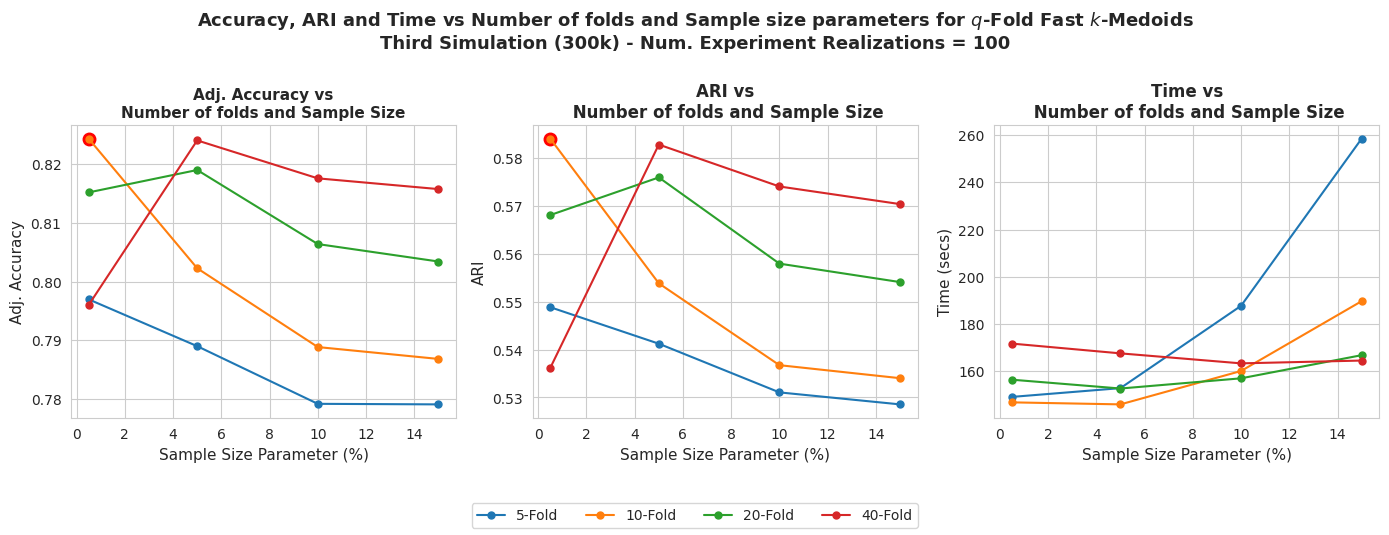

In [34]:
best_combi_acc = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]
best_combi_ari = dfs['ARI'].sort_values(by='ARI', ascending=False).iloc[0]
best_combi_time = dfs['time'].sort_values(by='time', ascending=True).iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(14, 5.5), sharex=True)

# Primer subplot: Accuracy
ax1 = axes[0]
ax1.plot(best_combi_acc['frac_sample_sizes'] * 100, best_combi_acc['adj_accuracy'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['adj_accuracy']['n_splits'].unique()):
    subset = dfs['adj_accuracy'][dfs['adj_accuracy']['n_splits'] == k1]
    ax1.plot(subset['frac_sample_sizes'] * 100, subset['adj_accuracy'], marker='o', markersize=5, label=f"{k1}-Fold")
ax1.set_title("Adj. Accuracy vs\nNumber of folds and Sample Size", fontsize=11, fontweight='bold')
ax1.set_xlabel("Sample Size Parameter (%)", size = 11)
ax1.set_ylabel("Adj. Accuracy", size = 11)

# Segundo subplot: Accuracy
ax2 = axes[1]
ax2.plot(best_combi_ari['frac_sample_sizes'] * 100, best_combi_ari['ARI'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['ARI']['n_splits'].unique()):
    subset = dfs['ARI'][dfs['ARI']['n_splits'] == k1]
    ax2.plot(subset['frac_sample_sizes'] * 100, subset['ARI'], marker='o', markersize=5, label=f"{k1}-Fold")
ax2.set_title("ARI vs\n Number of folds and Sample Size", fontsize=12, fontweight='bold')
ax2.set_xlabel("Sample Size Parameter (%)", size = 11)
ax2.set_ylabel("ARI", size = 11)

# Tercer subplot: Time
ax3 = axes[2]
#ax3.plot(best_combi_time['frac_sample_sizes'] * 100, best_combi_time['time'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['time']['n_splits'].unique()):
    subset = dfs['time'][dfs['time']['n_splits'] == k1]
    ax3.plot(subset['frac_sample_sizes'] * 100, subset['time'], marker='o', markersize=5, label=f"{k1}-Fold")
ax3.set_title("Time vs\n Number of folds and Sample Size", fontsize=12, fontweight='bold')
ax3.set_xlabel("Sample Size Parameter (%)", size = 11)
ax3.set_ylabel("Time (secs)", size = 11)

# Título general
fig.suptitle("Accuracy, ARI and Time vs Number of folds and Sample size parameters for $q$-Fold Fast $k$-Medoids\nThird Simulation (300k) - Num. Experiment Realizations = 100", fontsize=13, fontweight='bold', y=0.95)

# Leyenda común abajo
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plot_filename = f'plot_results_exp_3_simu_4_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()


**Nota:** si queremos que los datos de tiempo sean coherentes con mi pc personal (realista con un PC de  usuario normal) hay que multiplicarlos por 2, ya que el experimento ha sido corrido con el server, y en base a mis pruebas piloto, el serber acorta los tiempos a la mitad, aprox.


In [10]:
# Results as table
avg_results_df = pd.concat([dfs['adj_accuracy'], dfs['ARI']['ARI'], dfs['time']['time']], axis=1)
avg_results_df

,n_splits,frac_sample_sizes,adj_accuracy,ARI,time
0,5,0.005,0.796967,0.548825,149.114996
1,5,0.050,0.788991,0.541217,152.830869
2,5,0.100,0.779167,0.531066,187.688437
3,5,0.150,0.779073,0.528565,258.485359
4,10,0.005,0.824339,0.583965,146.806953
5,10,0.050,0.802264,0.553802,145.950345
6,10,0.100,0.788838,0.536739,160.090535
7,10,0.150,0.786816,0.534027,189.664150
8,20,0.005,0.815182,0.568036,156.407557
9,20,0.050,0.819001,0.575883,152.667822


In [11]:
best_frac_sample_size = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]['frac_sample_sizes']
best_n_splits = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]['n_splits']
n = len(X)
split_ratio = np.round((best_n_splits/n)*100,3) # best_split = split_ratio * n

print(' split_ratio', split_ratio, '\n', 'best_n_splits', best_n_splits, '\n', 'best_frac_sample_size', best_frac_sample_size)

 split_ratio 0.003 
 best_n_splits 10.0 
 best_frac_sample_size 0.005


## Experiment 4: Empirical comparison to other existing algorithms (section 3.5)

In [22]:
run_experiment_4 = True

In [9]:
from FastKmedoids.models import FastKmedoidsGGower, FoldFastKmedoidsGGower
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import (KMeans, AgglomerativeClustering,
                             SpectralBiclustering, SpectralCoclustering, Birch, 
                             BisectingKMeans, MiniBatchKMeans)
from sklearn.mixture import GaussianMixture
from clustpy.partition import SubKmeans, LDAKmeans
from clustpy.hierarchical import Diana

experiment_4_config = get_config_exp_4_sim_4()

quant_distances_names = ['robust_mahalanobis']
binary_distances_names = ['jaccard', 'sokal']
multiclass_distances_names = ['hamming']
robust_method = ['MAD', 'trimmed', 'winsorized']

GGower_distances_names = get_GGower_distances_names(quant_distances_names, binary_distances_names, multiclass_distances_names, robust_method)

#################################################################################################

models = {
    
    'KMeans': KMeans(
        n_clusters=experiment_4_config['n_clusters'], 
        random_state=experiment_4_config['random_state'], 
        init='k-means++', 
        n_init='auto', 
        max_iter=experiment_4_config['max_iter']),

    'CLARA': CLARA(n_clusters=experiment_4_config['n_clusters'], 
                   metric='euclidean'),

    'LDAKmeans': LDAKmeans(n_clusters=experiment_4_config['n_clusters']),

    'SubKmeans': SubKmeans(n_clusters=experiment_4_config['n_clusters']),

    'GaussianMixture': GaussianMixture(n_components=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state']),

    'SpectralBiclustering': SpectralBiclustering(n_clusters=experiment_4_config['n_clusters']),

    'SpectralCoclustering': SpectralCoclustering(n_clusters=experiment_4_config['n_clusters']),

    'BisectingKMeans': BisectingKMeans(n_clusters=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state'], 
                                       max_iter=experiment_4_config['max_iter']),

    'MiniBatchKMeans': MiniBatchKMeans(n_clusters=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state'], 
                                       max_iter=experiment_4_config['max_iter'])
                                       
}

#################################################################################################

for d in GGower_distances_names:

    d1, d2, d3 = d.split('-')

    if 'robust' in d1:
        r = d1.split('_')[-1]
        d1 = '_'.join(d1.split('_')[:2])
        
    models[f'FastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FastKmedoidsGGower(
            n_clusters=experiment_4_config['n_clusters'], 
            method=experiment_4_config['method'], 
            init=experiment_4_config['init'], 
            max_iter=experiment_4_config['max_iter'], 
            random_state=experiment_4_config['random_state'],
            frac_sample_size=experiment_4_config['frac_sample_size'], 
            p1=experiment_4_config['p1'], 
            p2=experiment_4_config['p2'], 
            p3=experiment_4_config['p3'], 
            d1=d1, 
            d2=d2, 
            d3=d3, 
            robust_method=r, 
            alpha=experiment_4_config['alpha'], 
            epsilon=experiment_4_config['epsilon'], 
            n_iters=experiment_4_config['n_iters'],
            VG_sample_size=experiment_4_config['VG_sample_size'], 
            VG_n_samples=experiment_4_config['VG_n_samples']) 

    models[f'FoldFastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FoldFastKmedoidsGGower(
            n_clusters=experiment_4_config['n_clusters'], 
            method=experiment_4_config['method'], 
            init=experiment_4_config['init'], 
            max_iter=experiment_4_config['max_iter'], 
            random_state=experiment_4_config['random_state'],
            frac_sample_size=experiment_4_config['frac_sample_size'], 
            p1=experiment_4_config['p1'], 
            p2=experiment_4_config['p2'], 
            p3=experiment_4_config['p3'], 
            d1=d1, 
            d2=d2, 
            d3=d3, 
            robust_method=r, 
            alpha=experiment_4_config['alpha'], 
            epsilon=experiment_4_config['epsilon'], 
            n_iters=experiment_4_config['n_iters'],
            VG_sample_size=experiment_4_config['VG_sample_size'], 
            VG_n_samples=experiment_4_config['VG_n_samples'],
            n_splits=experiment_4_config['n_splits'], 
            shuffle=experiment_4_config['shuffle'], 
            kfold_random_state=experiment_4_config['kfold_random_state']) 

In [ ]:
if run_experiment_4: 
   
    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', 'results', 'results_experiment_4', 'simulation_3')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('chunk_id', chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)        

            X, y = get_simulation_4(
                random_state=random_state, 
                return_outlier_idx=False)
            
            results[random_state] = make_experiment_4(
                X=X, 
                y=y, 
                models=models)

        # Save results
        results_filename = f'results_exp_4_simu_4_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 100 realizations: 
## Personal compute: 1370 + 481  mins =  hours 

chunks:   0%|          | 0/12 [00:00<?, ?chunks/s]

chunk_id 22
random_state_chunk: [68237, 87617, 54984]
random_state: 68237
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:01<00:00,  6.20s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:03<00:00,  6.35s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:00<00:00,  6.04s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:05<00:00,  6.57s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:13<00:00,  7.36s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:29<00:00,  8.93s/it]


random_state: 87617
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:17<00:00,  7.79s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.81s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:23<00:00,  8.30s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:29<00:00,  8.92s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.25s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:15<00:00,  7.53s/it]


random_state: 54984
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.83s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.84s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.73s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.26s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:13<00:00,  7.34s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   8%|▊         | 1/12 [43:27<7:58:05, 2607.73s/chunks]

chunk_id 23
random_state_chunk: [49089, 66855, 4173]
random_state: 49089
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.61s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.64s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:05<00:00,  6.54s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:15<00:00,  7.56s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:11<00:00,  7.11s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:14<00:00,  7.49s/it]


random_state: 66855
KMeans
CLARA
LDAKmeans
SubKmeans


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.89s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.71s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.70s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.01s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:16<00:00,  7.63s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:16<00:00,  7.62s/it]


random_state: 4173
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:09<00:00,  6.93s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:14<00:00,  7.43s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:09<00:00,  6.99s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:15<00:00,  7.54s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:15<00:00,  7.55s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  17%|█▋        | 2/12 [1:26:12<7:10:24, 2582.50s/chunks]

chunk_id 24
random_state_chunk: [98850, 84600, 23784]
random_state: 98850
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.82s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.71s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.87s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:11<00:00,  7.20s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:14<00:00,  7.42s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:15<00:00,  7.57s/it]


random_state: 84600
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.90s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.83s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.68s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:15<00:00,  7.58s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:20<00:00,  8.04s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:17<00:00,  7.71s/it]


random_state: 23784
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.81s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:14<00:00,  7.41s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.72s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.25s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:13<00:00,  7.34s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  25%|██▌       | 3/12 [2:08:51<6:25:47, 2571.96s/chunks]

chunk_id 25
random_state_chunk: [95135, 10827, 63819]
random_state: 95135
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.69s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.68s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.69s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.05s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:13<00:00,  7.38s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:13<00:00,  7.31s/it]


random_state: 10827
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:05<00:00,  6.60s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:05<00:00,  6.54s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.70s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:13<00:00,  7.32s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:16<00:00,  7.66s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:16<00:00,  7.69s/it]


random_state: 63819
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.03s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:11<00:00,  7.12s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:09<00:00,  6.95s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:20<00:00,  8.07s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:17<00:00,  7.77s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  33%|███▎      | 4/12 [2:51:33<5:42:24, 2568.01s/chunks]

chunk_id 26
random_state_chunk: [86255, 34326, 22298]
random_state: 86255
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.72s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.77s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:05<00:00,  6.59s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.20s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.06s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.26s/it]


random_state: 34326
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:05<00:00,  6.55s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.07s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:09<00:00,  6.93s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.27s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.10s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.71s/it]


random_state: 22298
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.10s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.84s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.84s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:15<00:00,  7.53s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.10s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  42%|████▏     | 5/12 [3:33:19<4:56:58, 2545.56s/chunks]

chunk_id 27
random_state_chunk: [43896, 44160, 72640]
random_state: 43896
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.63s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.65s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.84s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:11<00:00,  7.15s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:15<00:00,  7.57s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:13<00:00,  7.40s/it]


random_state: 44160
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.78s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.74s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:09<00:00,  6.97s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:15<00:00,  7.53s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:23<00:00,  8.34s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:19<00:00,  7.93s/it]


random_state: 72640
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:14<00:00,  7.42s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.04s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:11<00:00,  7.11s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:19<00:00,  7.95s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.28s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  50%|█████     | 6/12 [4:16:41<4:16:28, 2564.83s/chunks]

chunk_id 28
random_state_chunk: [51274, 9606, 94779]
random_state: 51274
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.62s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:05<00:00,  6.60s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.83s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:15<00:00,  7.50s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:14<00:00,  7.46s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:13<00:00,  7.36s/it]


random_state: 9606
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.89s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:09<00:00,  6.91s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:09<00:00,  6.98s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:16<00:00,  7.61s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:16<00:00,  7.64s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:15<00:00,  7.56s/it]


random_state: 94779
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.88s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.66s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.85s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.23s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:17<00:00,  7.79s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  58%|█████▊    | 7/12 [4:59:39<3:34:05, 2569.14s/chunks]

chunk_id 29
random_state_chunk: [59869, 50810, 75126]
random_state: 59869
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.71s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.89s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.75s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:14<00:00,  7.45s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:13<00:00,  7.36s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:13<00:00,  7.38s/it]


random_state: 50810
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:11<00:00,  7.13s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.66s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.84s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.27s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:15<00:00,  7.56s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:17<00:00,  7.77s/it]


random_state: 75126
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.07s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.71s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.73s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.28s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:13<00:00,  7.38s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  67%|██████▋   | 8/12 [5:42:11<2:50:54, 2563.53s/chunks]

chunk_id 30
random_state_chunk: [44054, 2137, 24780]
random_state: 44054
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:05<00:00,  6.57s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.72s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.70s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.03s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:19<00:00,  7.95s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:13<00:00,  7.40s/it]


random_state: 2137
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.82s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.08s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.75s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:21<00:00,  8.11s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:16<00:00,  7.69s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.28s/it]


random_state: 24780
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.74s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.70s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.60s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.28s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:14<00:00,  7.45s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  75%|███████▌  | 9/12 [6:24:37<2:07:54, 2558.21s/chunks]

chunk_id 31
random_state_chunk: [76834, 11554, 82354]
random_state: 76834
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:05<00:00,  6.57s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.67s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.84s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:14<00:00,  7.43s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:18<00:00,  7.89s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:11<00:00,  7.15s/it]


random_state: 11554
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:09<00:00,  6.94s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.88s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.65s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:16<00:00,  7.64s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:13<00:00,  7.31s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:15<00:00,  7.54s/it]


random_state: 82354
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.09s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.84s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:16<00:00,  7.64s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:11<00:00,  7.18s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.26s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  83%|████████▎ | 10/12 [7:07:18<1:25:17, 2558.78s/chunks]

chunk_id 32
random_state_chunk: [47646, 1681, 46126]
random_state: 47646
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.68s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.82s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.74s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:14<00:00,  7.47s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:16<00:00,  7.60s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.29s/it]


random_state: 1681
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.01s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.77s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.72s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:16<00:00,  7.64s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.07s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.25s/it]


random_state: 46126
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:03<00:00,  6.39s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.78s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.87s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:14<00:00,  7.49s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:15<00:00,  7.52s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  92%|█████████▏| 11/12 [7:49:48<42:36, 2556.22s/chunks]  

chunk_id 33
random_state_chunk: [30032]
random_state: 30032
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.71s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.78s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.83s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.27s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:14<00:00,  7.46s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks: 100%|██████████| 12/12 [8:03:47<00:00, 2418.92s/chunks]


In [25]:
if run_experiment_4: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', 'results', 'results_experiment_4', 'simulation_3')
    results_chunk = {}
    for chunk_id in chunk_ids:
        if chunk_id < 22:
            file_id = '20250801_232218'
        else:
             file_id = '20250803_140655'
        results_filename = f'results_exp_4_simu_4_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_4_simu_4_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [5]:
# Open merged/joined results 
file_id = '20250803_140655'
results_filename = f'results_exp_4_simu_4_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', 'results', 'results_experiment_4', 'simulation_3')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [10]:
model_names = list(models.keys())

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=model_names
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=model_names
)

In [15]:
not_feasible_methods = ['DipInit', 'Spectral-Clustering', 'KMedoids-euclidean', 'Diana', 'AgglomerativeClustering', 'Birch'] # based on previous (TFM) experiments

for model_name in not_feasible_methods:
    avg_results['adj_labels'][model_name] = None
    avg_results['labels'][model_name] = None
    avg_results['adj_accuracy'][model_name] = 0
    avg_results['ARI'][model_name] = 0
    avg_results['time'][model_name] = 0

model_names = np.array(list(avg_results['adj_accuracy'].keys()))
avg_adj_accuracy = np.array(list(avg_results['adj_accuracy'].values()))
avg_ari = np.array(list(avg_results['ARI'].values()))
avg_time = np.array(list(avg_results['time'].values()))
idx_sorted = np.argsort(-avg_adj_accuracy) 
#idx_sorted = np.argsort(-avg_ari) 

our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]

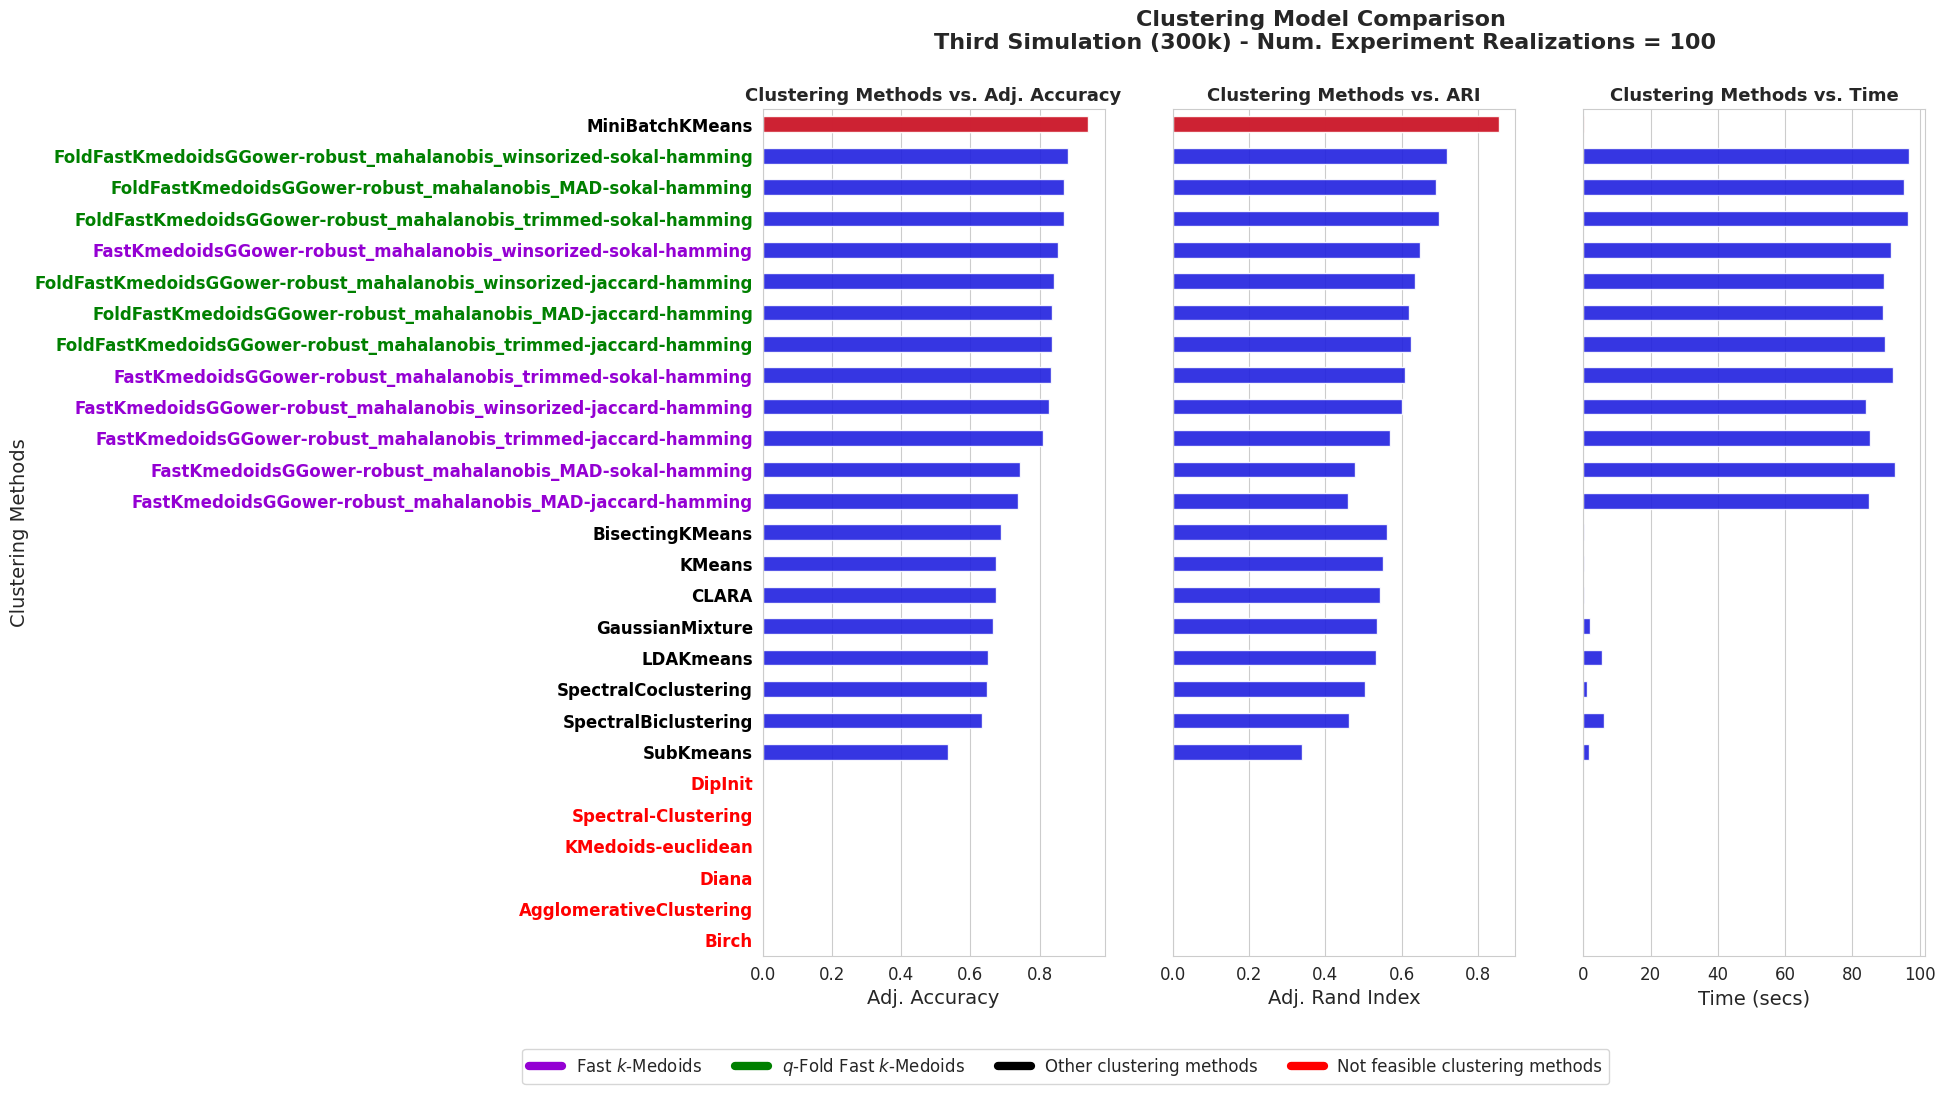

In [36]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(x=avg_adj_accuracy[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(x=[avg_adj_accuracy[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(x=avg_ari[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(x=[avg_ari[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(x=avg_time[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(x=[avg_time[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[2])

axes[0].set_ylabel('Clustering Methods', size=14)
axes[0].set_xlabel('Adj. Accuracy', size=14)
#axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs. Adj. Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=14)
#axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs. ARI', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=14)
#axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs. Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    elif label.get_text() in not_feasible_methods:
        label.set_weight('bold')
        label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$q$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

fig.suptitle("Clustering Model Comparison \nThird Simulation (300k) - Num. Experiment Realizations = 100", fontsize=16, fontweight='bold', y=0.97)

plot_filename = f'plot_results_exp_4_simu_4_{file_id}_acc.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

**Nota:** si queremos que los datos de tiempo sean coherentes con mi pc personal (realista con un PC de  usuario normal) hay que multiplicarlos por 2, ya que el experimento ha sido corrido con el server, y en base a mis pruebas piloto, el serber acorta los tiempos a la mitad, aprox.


In [11]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'models'
avg_results_df = avg_results_df.drop(['labels', 'adj_labels'], axis=1)
avg_results_df_sorted_acc = avg_results_df.sort_values(by='adj_accuracy', ascending=False)
avg_results_df_sorted_ari = avg_results_df.sort_values(by='ARI', ascending=False)

In [13]:
avg_results_df_sorted_acc

,time,adj_accuracy,ARI
models,,,
MiniBatchKMeans,0.158736,0.940379,0.853819
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,96.805782,0.881969,0.718133
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,95.391142,0.870075,0.688750
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,96.413069,0.869642,0.696396
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,91.494450,0.852172,0.648384
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,89.420037,0.841109,0.634662
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming,88.972284,0.836040,0.619665
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,89.760816,0.835995,0.625043
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,92.052074,0.831951,0.609566


In [12]:
avg_results_df_sorted_ari

,time,adj_accuracy,ARI
models,,,
MiniBatchKMeans,0.158736,0.940379,0.853819
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,96.805782,0.881969,0.718133
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,96.413069,0.869642,0.696396
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,95.391142,0.870075,0.688750
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,91.494450,0.852172,0.648384
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,89.420037,0.841109,0.634662
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,89.760816,0.835995,0.625043
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming,88.972284,0.836040,0.619665
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,92.052074,0.831951,0.609566


---

In [27]:
random_state_mds = 35084

X, y, outliers_idx = get_simulation_4(random_state=random_state_mds, return_outlier_idx=True)

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_state_mds) 

fastGG = FastGGowerDistMatrix(frac_sample_size=0.008, random_state=random_state_mds, p1=4, p2=2, p3=2, 
                 d1='robust_mahalanobis', d2='sokal', d3='hamming', 
                 robust_method='winsorized', alpha=0.05)

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GGower)

# Time: 52 secs

/home/fabio/fabio_scielzo_ortiz/tasks/.venv/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [28]:
outliers_bool = np.array([0 if x not in outliers_idx else 1 for x in range(0, len(X))])

sorted_methods_accuracy = list(avg_results_df_sorted_acc.index)

our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['KMeans', 'GaussianMixture']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast k-medoids' if x in our_methods_1 else 'Best q-Fold Fast k-medoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: results[random_state_mds]['adj_labels'][method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: results[random_state_mds]['adj_accuracy'][method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: results[random_state_mds]['time'][method] for method in methods_to_plot}


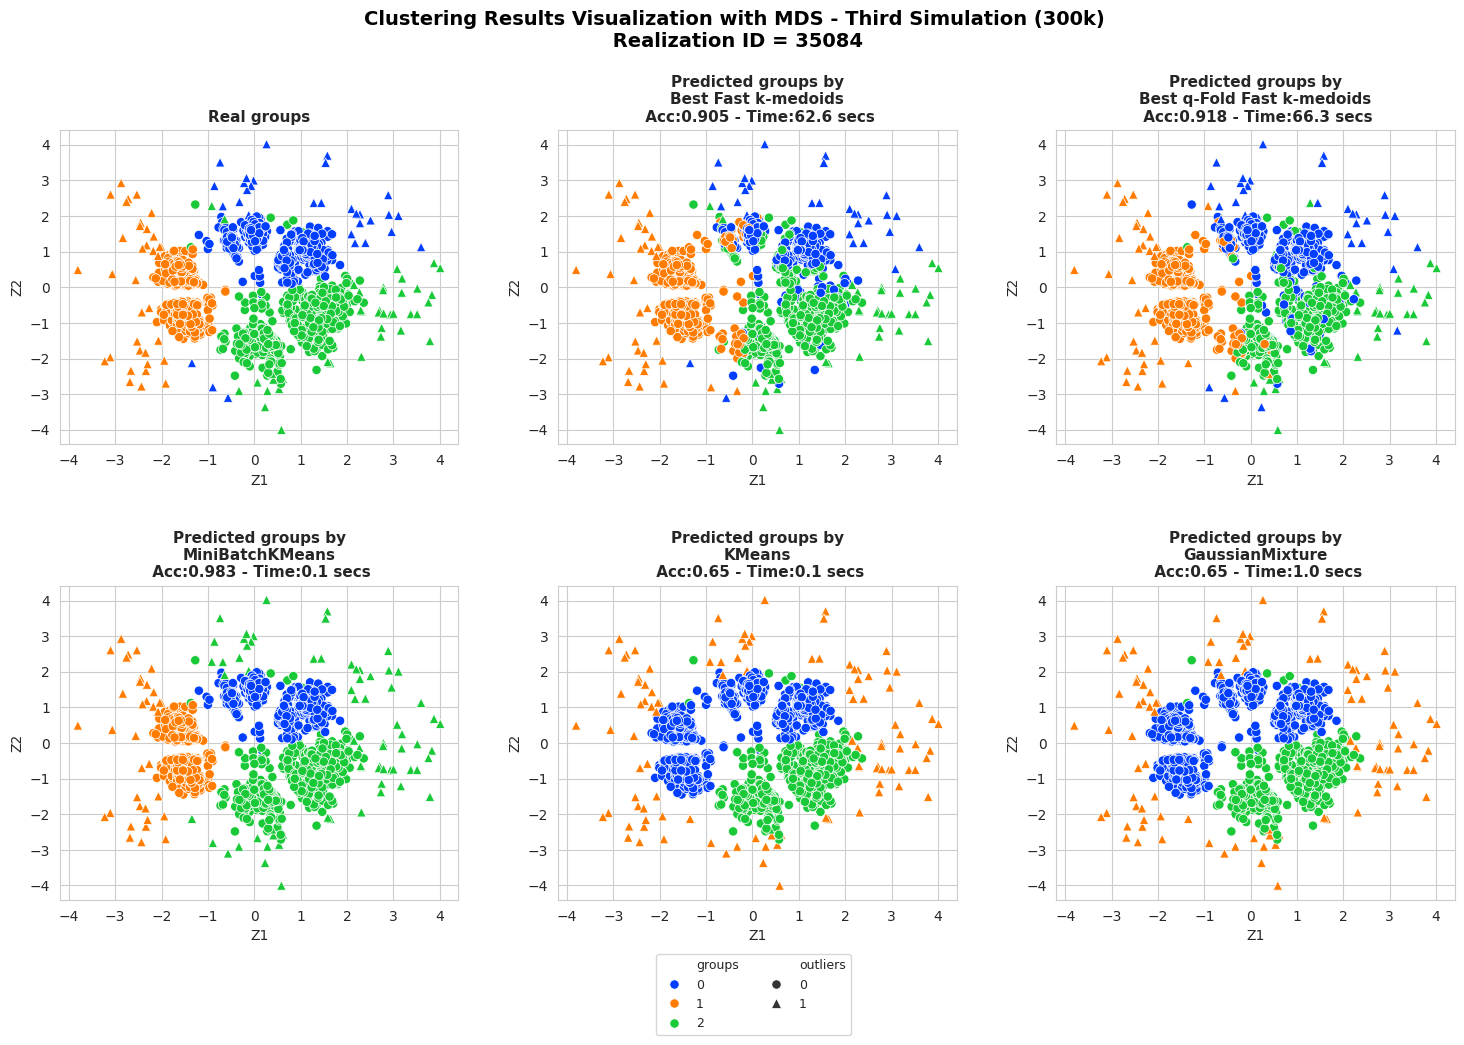

In [29]:
plot_filename = f'mds_plot_exp_4_simu_4_{file_id}.png'
results_folder_path = os.path.join(current_path, '..', 'results', 'results_experiment_4', 'simulation_3')
plot_save_path = os.path.join(results_folder_path, plot_filename)

clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[fastGG.sample_index],
                                     title=f"Clustering Results Visualization with MDS - Third Simulation (300k)\n Realization ID = {random_state_mds}", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(18,10), bbox_to_anchor=(0.75,-1.9), 
                                     title_size=14, title_weight='bold', 
                                     subtitles_size=11,
                                     points_size=45, title_height=1, 
                                     wspace=0.25, hspace=0.45, 
                                     outliers_boolean=outliers_bool[fastGG.sample_index],
                                     n_cols_legend=2, legend_title='', legend_size=9, 
                                     save = True, file_name = plot_save_path
)